In [1]:
# I want to see how the expected SFS changes when I change the bottleneck size 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import moments
from dadi import Numerics, PhiManip, Integration
from dadi.Spectrum_mod import Spectrum

ModuleNotFoundError: No module named 'timestamp'

In [2]:
!pip install moments timestamp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for moments: filename=Moments-2.0-py3-none-any.whl size=84444 sha256=f7e1c79f0eb003fd7d6deedafff09506a89e2f44e1cdf5dbef2d3e208f6d00f9
  Stored in directory: /home/akapoor/.cache/pip/wheels/36/b1/bc/f84182a1885389e8554e836e3b35be60e2647c37ae337635e6
Successfully built moments

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


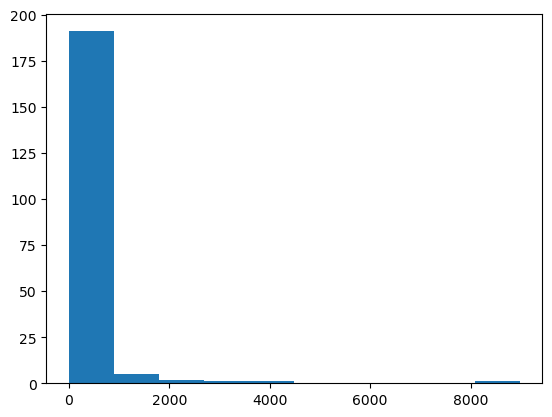

In [2]:
input_theta = 10000

# Let's define the ground truth parameter values. We will try to recover these values using the moments optimization procedure.

sampled_params = {}

sampled_params['N0'] = 10000
sampled_params['Nb'] = 7000
sampled_params['N_recover'] = 9000
sampled_params['t_bottleneck_end'] = 400
sampled_params['t_bottleneck_start'] = 600


nuB = sampled_params['Nb']/sampled_params['N0']
nuF = sampled_params['N_recover']/sampled_params['N0']
TB = (sampled_params['t_bottleneck_start'] - sampled_params['t_bottleneck_end'])/(2*sampled_params['N0'])
TF = sampled_params['t_bottleneck_end']/(2*sampled_params['N0'])

params = [nuB, nuF, TB, TF]
model_func = moments.Demographics1D.three_epoch
model = model_func(params, [200])
model = input_theta * model
data = model.sample()

plt.figure()
plt.hist(np.array(data))
plt.show()
# plt.savefig('bottleneck_sfs.png')


In [3]:
print(f'Optimal Parameters: {params}')

Optimal Parameters: [0.7, 0.9, 0.01, 0.02]


In [4]:
p_guess = [0.75, 0.85, 0.1, 0.01]
lower_bound = [0.001, 0.001, 0.001, 0.001]
upper_bound = [1, 1, 1, 1]

p_guess = moments.Misc.perturb_params(
    p_guess, lower_bound=lower_bound, upper_bound=upper_bound, fold = 2)

opt_params = moments.Inference.optimize_log_fmin(
    p_guess, data, model_func,
    lower_bound=lower_bound, upper_bound=upper_bound,
    verbose=20) # report every 20 iterations


20      , -785.741    , array([ 0.987367   ,  0.861425   ,  0.0796225  ,  0.00814635 ])
40      , -781.744    , array([ 0.987662   ,  0.820886   ,  0.0790306  ,  0.00808556 ])


60      , -778.398    , array([ 0.987917   ,  0.823786   ,  0.0677761  ,  0.0118469  ])
80      , -777.025    , array([ 0.987913   ,  0.823266   ,  0.0634299  ,  0.0170416  ])
100     , -774.119    , array([ 0.987862   ,  0.860012   ,  0.0525133  ,  0.0312102  ])
120     , -773.991    , array([ 0.987842   ,  0.867409   ,  0.051359   ,  0.0336818  ])
140     , -773.99     , array([ 0.987841   ,  0.86771    ,  0.0513572  ,  0.0335046  ])
160     , -773.99     , array([ 0.987845   ,  0.867624   ,  0.0513293  ,  0.033465   ])
180     , -773.99     , array([ 0.987881   ,  0.867535   ,  0.05098    ,  0.033497   ])
200     , -773.988    , array([ 0.988473   ,  0.867777   ,  0.0449352  ,  0.0338737  ])
220     , -773.978    , array([ 0.992719   ,  0.868958   ,  0.0183075  ,  0.0362589  ])
240     , -773.974    , array([ 0.993756   ,  0.868674   ,  0.0148242  ,  0.0359951  ])
260     , -773.972    , array([ 0.997206   ,  0.868669   ,  0.00730406 ,  0.0360192  ])
280     , -773.971    , array([ 

In [5]:
print(f'Found params: {opt_params}')
print(f'Actual Params: {params}')

Found params: [0.99999989 0.86857916 0.00411509 0.03621515]
Actual Params: [0.7, 0.9, 0.01, 0.02]


In [6]:
# Bottleneck size, recovery size, TB, TF

After suggestion from Andy: define my own demographic model where I am not estimating the bottleneck duration

In [48]:
def bottleneck_model(params, ns, pts = 400):
    """
    params = (nuB,nuF,TF)
    ns = (n1,)

    nuB: Ratio of bottleneck population size to ancient pop size
    nuF: Ratio of contemporary to ancient pop size
    TF: Time since bottleneck recovery (in units of 2*Na generations) 

    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    # TB = 0.1
    nuB,nuF,TB, TF = params

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, TB, nuB)
    phi = Integration.one_pop(phi, xx, TF, nuF)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs

In [49]:
params = [nuB, nuF, TB, TF]


In [50]:
data = bottleneck_model(params, [100], 400)

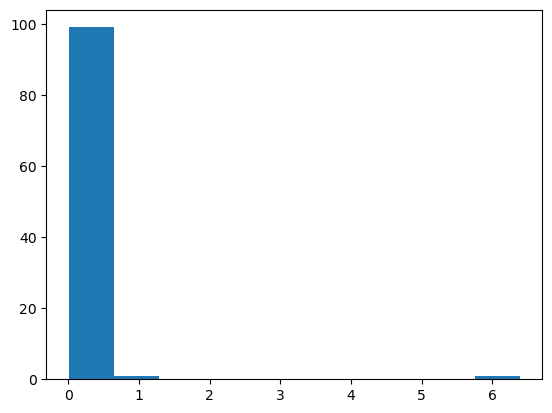

In [51]:
plt.figure()
plt.hist(np.array(data))
plt.show()

In [52]:
p_guess = [0.2, 0.3, 0.05, 0.005]
lower_bound = [1e-4, 1e-4, 1e-4, 1e-4]
upper_bound = [10, 10, 10, 10]
model_func = bottleneck_model

p_guess = moments.Misc.perturb_params(
    p_guess, lower_bound=lower_bound, upper_bound=upper_bound, fold = 0)


In [53]:
opt_params = moments.Inference.optimize_log_lbfgsb(
    p_guess, data, model_func,
    lower_bound=lower_bound, upper_bound=upper_bound,
    verbose=20) # report every 20 iterations

1860    , -13.625     , array([ 1.09326    ,  0.668512   ,  0.0298793  ,  0.00408249 ])
1880    , -13.6231    , array([ 0.925704   ,  0.683277   ,  0.0298587  ,  0.00420371 ])
1900    , -13.6227    , array([ 0.82602    ,  0.991192   ,  0.0300273  ,  0.00413541 ])


In [54]:
print(f'Found params: {opt_params}')
print(f'Actual Params: {params}')

Found params: [0.82529491 0.99765067 0.03003989 0.00414179]
Actual Params: [0.7, 0.9, 0.01, 0.02]


In [2]:
import msprime
import tskit

# Define the simulation parameters
population_size_initial = 10000
population_size_bottleneck = 1000
bottleneck_start_time = 0.05  # 0.05 * 4Ne generations ago
bottleneck_end_time = 0.03    # 0.03 * 4Ne generations ago
sample_size = 100
num_generations = 10  # number of generations post-bottleneck

# Define a demographic event sequence
demography = msprime.Demography()
demography.add_population(name="pop", initial_size=population_size_initial)

# Add a bottleneck event
demography.add_population_parameters_change(
    time=bottleneck_start_time, initial_size=population_size_bottleneck, population="pop"
)
demography.add_population_parameters_change(
    time=bottleneck_end_time, initial_size=population_size_initial, population="pop"
)

# Simulate the population
tree_sequence = msprime.sim_ancestry(
    samples=sample_size,
    demography=demography,
    sequence_length=1e6,  # 1 Mbp
    recombination_rate=1e-8  # Recombination rate per base per generation
)

# Introduce mutations
mutated_tree_sequence = msprime.sim_mutations(
    tree_sequence, rate=1e-8, model="binary"
)

# Save the tree sequence to a VCF file
with open("bottleneck_simulation.vcf", "w") as vcf_file:
    mutated_tree_sequence.write_vcf(vcf_file)

print("VCF file generated: bottleneck_simulation.vcf")

ValueError: Events must be time-sorted. Please use demography.sort_events()if you add events out of order.